In [2]:
# importing helper libraries
import numpy as np
import pandas as pd
# import machine learning libraries
import tensorflow as tf
from tensorflow import keras
# Importing data preprocessing techniques
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Data Reading, Downloaded from Yahoo Finance

In [3]:
data = pd.read_csv("../BTC-USD-2019-2024.csv")
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [4]:
data.isna().astype("int").sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [5]:
# we need to remove null or NaN value from our dataset
data.dropna(inplace=True)
data.isna().astype("int").sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [6]:
model_dir = "../models"

In [7]:
features = ["High", "Low", "Close", "Open", "Volume"]
required_data = data[features]
required_data.head()

,High,Low,Close,Open,Volume
0,468.174011,452.421997,457.334015,465.864014,21056800
1,456.859985,413.104004,424.440002,456.859985,34483200
2,427.834991,384.532013,394.795990,424.102997,37919700
3,423.295990,389.882996,408.903992,394.673004,36863600
4,412.425995,393.181000,398.821014,408.084991,26580100


# Data Preprocessing

Use the data before 3/19/2024 for training, and 3/19/2024 to 5/19/2024 for testing

In [8]:
idx_split = data[data.Date == "2024-03-19"].index[0]
idx_split

3471

In [9]:
# train_data_length = int(0.9 * len(required_data))
train_data_length = idx_split
print(f"training data fraction : {train_data_length/len(required_data)}")

training data fraction : 0.9827293318233296


In [10]:
# Before we normalize the data, we need to split the data into train and test split, so that data snooping can be
# avoided

train_data = required_data.iloc[:train_data_length]
test_data = required_data.iloc[train_data_length:]

print(f"Training data : {train_data.shape}")
print(f"Testing data : {test_data.shape}")

Training data : (3471, 5)
Testing data : (61, 5)


In [11]:
# Data Normalization
# This will scale the data between -1 and 1
normalizer = MinMaxScaler(feature_range = (-1, 1))
# Fit the normalizer on the train data only
normalizer.fit(train_data)

# converting the train data
train_data = normalizer.transform(train_data)
test_data  = normalizer.transform(test_data)

print(f"Training data : {train_data.shape}")
print(f"Testing data : {test_data.shape}")

Training data : (3471, 5)
Testing data : (61, 5)


In [12]:
import pickle
def save_preprocessor(preprocessor, filename=f"{model_dir}/preprocessor.prec"):
    with open(filename, "wb") as file:
        pickle.dump(preprocessor, file)
save_preprocessor(normalizer)

In [13]:
# checking the range of train data and test data
print(f"Maximum and minimum value of training data : {np.max(train_data), np.min(train_data)}")
print(f"Maximum and minimum value of testing  data : {np.max(test_data), np.min(test_data)}")

Maximum and minimum value of training data : (1.0, -1.0)
Maximum and minimum value of testing  data : (0.971859279181212, -0.9213901004818578)


In [14]:
# this piece of code creates the data where features and targets are multivariate

def create_window_split_with_target_multivariate(data, window_size, horizon=1, stride=1):
    """
    Function to split a multivariate time series data into overlapping windows and generate target variables.
    
    Parameters:
        data (numpy.ndarray): The input multivariate time series data with shape (num_samples, num_features).
        window_size (int): Size of each window.
        horizon (int): Forecast horizon, i.e., number of future time steps to predict. Default is 1.
        stride (int): The stride or step size between consecutive windows. Default is 1.
    
    Returns:
        numpy.ndarray, numpy.ndarray: Arrays containing the split windows and corresponding target variables.
    """
    num_samples = len(data)
    num_features = data.shape[1]
    num_windows = (num_samples - window_size - horizon) // stride + 1
    windows = np.zeros((num_windows, window_size, num_features))
    targets = np.zeros((num_windows, num_features))
    
    for i in range(num_windows):
        start_index = i * stride
        end_index = start_index + window_size
        windows[i] = data[start_index:end_index]
        targets[i] = data[end_index + horizon - 1]  # Assuming the target is the value at the end of the forecast horizon
    
    return windows, targets


window_size = 15
horizon = 1
stride = 1

train_features, train_lables = create_window_split_with_target_multivariate(train_data, window_size, horizon, stride)
test_features, test_lables = create_window_split_with_target_multivariate(test_data, window_size, horizon, stride)


print(f"Training Data : {train_features.shape, train_lables.shape}")
print(f"Testing Data : {test_features.shape, test_lables.shape}")

Training Data : ((3456, 15, 5), (3456, 5))
Testing Data : ((46, 15, 5), (46, 5))


# Model Training and Evaluation

## GRU Models

Model 1: This model has 2 GRU layers with 128 units each and Group Normalization

In [15]:
from tensorflow.keras.layers import GRU

def make_gru128():
    return tf.keras.Sequential(
        [
            keras.layers.Input(shape = (15, len(features))),
            GRU(units = 128, activation = "gelu", return_sequences = True),
            keras.layers.GroupNormalization(),
            GRU(units = 128, activation = "gelu"),
            keras.layers.GroupNormalization(),
            keras.layers.Dense(units=64, activation="gelu"),
            keras.layers.Dense(units=len(features), activation="tanh")  
        ],
    )
gru128 = make_gru128()
gru128.summary()

2024-05-19 19:50:09.405303: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-19 19:50:09.445470: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 15, 128)        │        51,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ group_normalization             │ (None, 15, 128)        │           256 │
│ (GroupNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 128)            │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ group_normalization_1           │ (None, 128)            │           256 │
│ (GroupNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 160,005 (625.02 KB)

 Trainable params: 160,005 (625.02 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
def make_gru128b():
    return tf.keras.Sequential(
        [
            keras.layers.Input(shape = (15, len(features))),
            keras.layers.Bidirectional(GRU(units=128, activation="gelu", return_sequences=True)),
            keras.layers.GroupNormalization(),
            keras.layers.Bidirectional(GRU(units=128, activation="gelu")),
            keras.layers.GroupNormalization(),
            keras.layers.Dense(units=64, activation="gelu"),
            keras.layers.Dense(units=len(features), activation="tanh")  
        ]
    )
gru128b = make_gru128b()
gru128.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 15, 128)        │        51,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ group_normalization             │ (None, 15, 128)        │           256 │
│ (GroupNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 128)            │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ group_normalization_1           │ (None, 128)            │           256 │
│ (GroupNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 160,005 (625.02 KB)

 Trainable params: 160,005 (625.02 KB)

 Non-trainable params: 0 (0.00 B)

detect if the model has converge early

Model 2: This model has 2 GRU layers with 32 units each and Layer Normalization

In [17]:
def make_gru32():
    return tf.keras.Sequential(
        [
            keras.layers.Input(shape=(15, len(features))),
            GRU(units=32, activation="tanh", return_sequences=True),
            keras.layers.LayerNormalization(),
            GRU(units=32, activation="tanh"),
            keras.layers.LayerNormalization(),
            keras.layers.Dense(units=32, activation="tanh"),
            keras.layers.Dense(units=len(features))  
        ]
    )
gru32 = make_gru32()
gru32.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_4 (GRU)                     │ (None, 15, 32)         │         3,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization             │ (None, 15, 32)         │            64 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_5 (GRU)                     │ (None, 32)             │         6,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_1           │ (None, 32)             │            64 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,429 (44.64 KB)

 Trainable params: 11,429 (44.64 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
def make_gru32b():
    return tf.keras.Sequential(
        [
            keras.layers.Input(shape=(15, len(features))),
            keras.layers.Bidirectional(GRU(units=32, activation="tanh", return_sequences=True)),
            keras.layers.LayerNormalization(),
            keras.layers.Bidirectional(GRU(units=32, activation="tanh")),
            keras.layers.LayerNormalization(),
            keras.layers.Dense(units=32, activation="tanh"),
            keras.layers.Dense(units=len(features))  
        ]
    )
gru32b = make_gru32b()
gru32b.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_2 (Bidirectional) │ (None, 15, 64)         │         7,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_2           │ (None, 15, 64)         │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 64)             │        18,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_3           │ (None, 64)             │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,805 (112.52 KB)

 Trainable params: 28,805 (112.52 KB)

 Non-trainable params: 0 (0.00 B)

Model 3: RNN Model

In [19]:
def make_rnn128():
    return tf.keras.Sequential(
        [
            keras.layers.Input(shape=(15, len(features))),
            keras.layers.RNN(
                keras.layers.SimpleRNNCell(units=128, activation="gelu"),
                return_sequences=True
            ),
            keras.layers.GroupNormalization(),
            keras.layers.RNN(
                keras.layers.SimpleRNNCell(units=128, activation="gelu"),
            ),
            keras.layers.GroupNormalization(),
            keras.layers.Dense(units=64, activation="gelu"),
            keras.layers.Dense(units=len(features), activation="tanh")
        ]
    )
rnn128 = make_rnn128()
rnn128.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rnn (RNN)                       │ (None, 15, 128)        │        17,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ group_normalization_4           │ (None, 15, 128)        │           256 │
│ (GroupNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rnn_1 (RNN)                     │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ group_normalization_5           │ (None, 128)            │           256 │
│ (GroupNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,141 (231.02 KB)

 Trainable params: 59,141 (231.02 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
def make_rnn32():
    return tf.keras.Sequential(
        [
            keras.layers.Input(shape=(15, len(features))),
            keras.layers.RNN(
                keras.layers.SimpleRNNCell(units=64, activation="tanh"),
                return_sequences=True
            ),
            keras.layers.GroupNormalization(),
            keras.layers.RNN(
                keras.layers.SimpleRNNCell(units=64, activation="tanh"),
            ),
            keras.layers.GroupNormalization(),
            keras.layers.Dense(units=64, activation="tanh"),
            keras.layers.Dense(units=len(features), activation="tanh")
        ]
    )
rnn32 = make_rnn32()
rnn32.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rnn_2 (RNN)                     │ (None, 15, 64)         │         4,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ group_normalization_6           │ (None, 15, 64)         │           128 │
│ (GroupNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rnn_3 (RNN)                     │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ group_normalization_7           │ (None, 64)             │           128 │
│ (GroupNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,477 (68.27 KB)

 Trainable params: 17,477 (68.27 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
callbacks = []
early_stops = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=40)
callbacks.append(early_stops)

get model initializers in case we need to retrain the models

In [22]:
model_initalizers = dict([(key.replace("make_", ""), value) for key, value in locals().items() if key.startswith("make")])
model_initalizers

{'gru128': <function __main__.make_gru128()>,
 'gru128b': <function __main__.make_gru128b()>,
 'gru32': <function __main__.make_gru32()>,
 'gru32b': <function __main__.make_gru32b()>,
 'rnn128': <function __main__.make_rnn128()>,
 'rnn32': <function __main__.make_rnn32()>}

In [24]:
models = dict([(key, value) for key, value in locals().items() if value.__class__ == keras.Sequential and not key.startswith("_")])
models

{'gru128': <Sequential name=sequential, built=True>,
 'gru128b': <Sequential name=sequential_1, built=True>,
 'gru32': <Sequential name=sequential_2, built=True>,
 'gru32b': <Sequential name=sequential_3, built=True>,
 'rnn128': <Sequential name=sequential_4, built=True>,
 'rnn32': <Sequential name=sequential_5, built=True>}

train all models

In [21]:
histories = {}
for name, model in models.items():
    model.compile(optimizer=keras.optimizers.AdamW(learning_rate = 0.001, clipnorm=1.), loss = "mse", metrics = ["mse", "mae"])
    history = model.fit(train_features, train_lables, epochs=100, validation_split=0.1, callbacks=callbacks + [tf.keras.callbacks.ModelCheckpoint(f"{model_dir}/{name}.keras", save_best_only=True)])
    histories[name] = history

Epoch 1/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0465 - mae: 0.1161 - mse: 0.0465 - val_loss: 0.0079 - val_mae: 0.0746 - val_mse: 0.0079
Epoch 2/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0028 - mae: 0.0355 - mse: 0.0028 - val_loss: 0.0050 - val_mae: 0.0574 - val_mse: 0.0050
Epoch 3/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0017 - mae: 0.0275 - mse: 0.0017 - val_loss: 0.0037 - val_mae: 0.0471 - val_mse: 0.0037
Epoch 4/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0013 - mae: 0.0244 - mse: 0.0013 - val_loss: 0.0074 - val_mae: 0.0698 - val_mse: 0.0074
Epoch 5/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0013 - mae: 0.0224 - mse: 0.0013 - val_loss: 0.0029 - val_mae: 0.0394 - val_mse: 0.0029
Epoch 6/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0015 - mae: 0.0222 - mse: 0.0015 - val_loss: 0.0021 - val_mae: 0.0327 - val_mse: 0.0021
Epoch 7/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0015 - mae: 0.0218 - mse: 0.0015 - val

uncomment to retrain some of the models

In [27]:
to_retrain = {"gru32b"}
for name in to_retrain:
    models[name] = model_initalizers[name]()
    # reinitialize the model
    models[name].compile(optimizer=keras.optimizers.AdamW(learning_rate=0.001, clipvalue=.5), loss="mse", metrics=["mse", "mae"])
    history = models[name].fit(train_features, train_lables, epochs=100, validation_split=0.1, callbacks=callbacks + [tf.keras.callbacks.ModelCheckpoint(f"{name}-3.keras", save_best_only=True)])
    histories[name] = history

Epoch 1/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.2223 - mae: 0.2924 - mse: 0.2223 - val_loss: 0.0103 - val_mae: 0.0740 - val_mse: 0.0103
Epoch 2/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0052 - mae: 0.0539 - mse: 0.0052 - val_loss: 0.0050 - val_mae: 0.0522 - val_mse: 0.0050
Epoch 3/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0038 - mae: 0.0439 - mse: 0.0038 - val_loss: 0.0052 - val_mae: 0.0502 - val_mse: 0.0052
Epoch 4/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0036 - mae: 0.0403 - mse: 0.0036 - val_loss: 0.0043 - val_mae: 0.0466 - val_mse: 0.0043
Epoch 5/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0024 - mae: 0.0316 - mse: 0.0024 - val_loss: 0.0033 - val_mae: 0.0375 - val_mse: 0.0033
Epoch 6/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0021 - mae: 0.0299 - mse: 0.0021 - val_loss: 0.0029 - val_mae: 0.0401 - val_mse: 0.0029
Epoch 7/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0017 - mae: 0.0274 - mse: 0.0017 - val_loss:

NameError: name 'histories' is not defined

## Train the models

## Training progress

In [23]:
def model_name_to_linestyle(name):
    if name.startswith("gru"):
        if "b" in name:
            return ":"
        else:
            return "-"
    elif name.startswith("rnn"):
        return "-."
    else:
        return "--"

In [26]:
import matplotlib.pyplot as plt
def plot_training_progress(histories):
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    for name, history in histories.items():
        history = histories[name]
        train_loss = history.history["loss"]
        valid_loss = history.history["val_loss"]
        
        train_mae = history.history["mae"]
        valid_mae = history.history["val_mae"]
    
        axes[0].plot(range(len(valid_loss)), valid_loss, label=name, linestyle=model_name_to_linestyle(name))
        axes[1].plot(range(len(valid_mae)),  valid_mae,  label=name, linestyle=model_name_to_linestyle(name))
        axes[2].plot(range(len(train_loss)), train_loss, label=name, linestyle=model_name_to_linestyle(name))    
        axes[3].plot(range(len(train_mae)),  train_mae,  label=name, linestyle=model_name_to_linestyle(name))
    axes[0].set_title("Validation MSE vs Epochs")
    axes[1].set_title("Validation MAE vs Epochs")
    axes[2].set_title("Training MSE vs Epochs")
    axes[3].set_title("Training MAE vs Epochs")
    axes[0].set_ylabel("Loss value")
    for ax in axes:
        ax.set_xlabel("Epoch") 
        ax.set_yscale("log")
    axes[0].legend()
    plt.show()

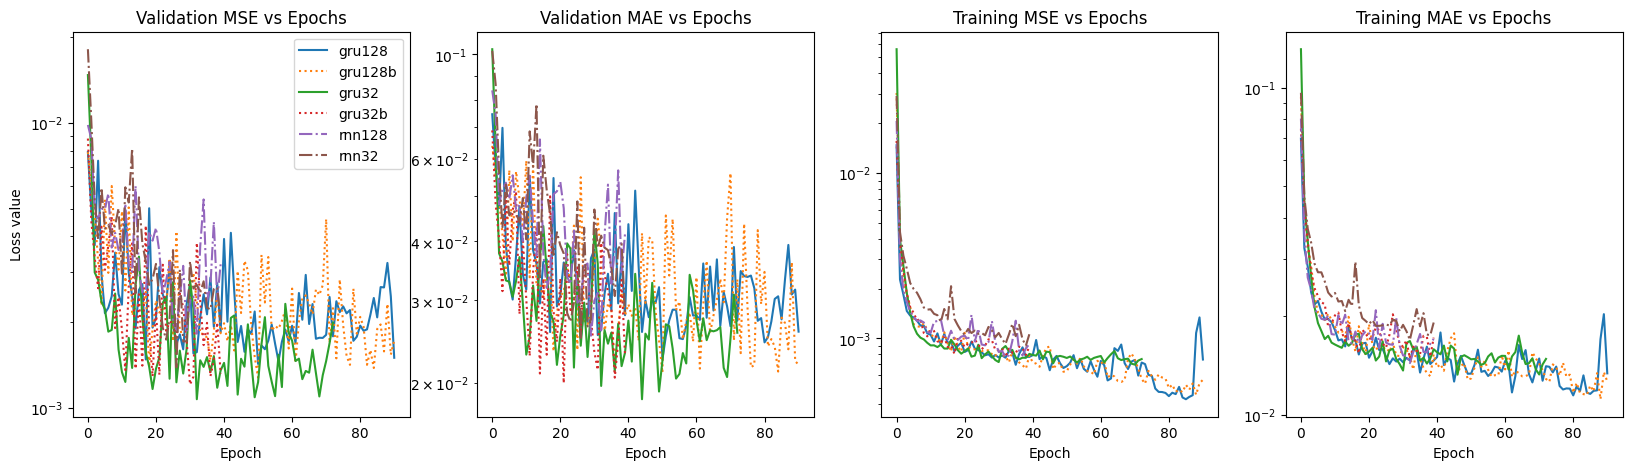

In [27]:
plot_training_progress(histories)

In [38]:
def plot(x, y, models):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    # true values
    axes[0].plot(y[:, 0], label = "True")
    axes[1].plot(y[:, 1], label = "True")
    axes[2].plot(y[:, 2], label = "True")
    for name, model in models.items():
        test_predicts = model.predict(x)
        
        axes[0].plot(test_predicts[:, 0], label=name, linestyle=model_name_to_linestyle(name))
        axes[0].set_title('High Value')
        axes[0].set_xlabel('Future Dates')
        axes[0].set_ylabel('Predicted values')
        
        axes[1].plot(test_predicts[:, 1], label=name, linestyle=model_name_to_linestyle(name))
        axes[1].set_title('Low Value')
        axes[1].set_xlabel('Future Dates')
        axes[1].set_ylabel('Predicted values')
        
        axes[2].plot(test_predicts[:, 2], label=name, linestyle=model_name_to_linestyle(name))
        axes[2].set_title('Close Value')
        axes[2].set_xlabel('Future Dates')
        axes[2].set_ylabel('Predicted values')
    axes[0].legend()
    plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


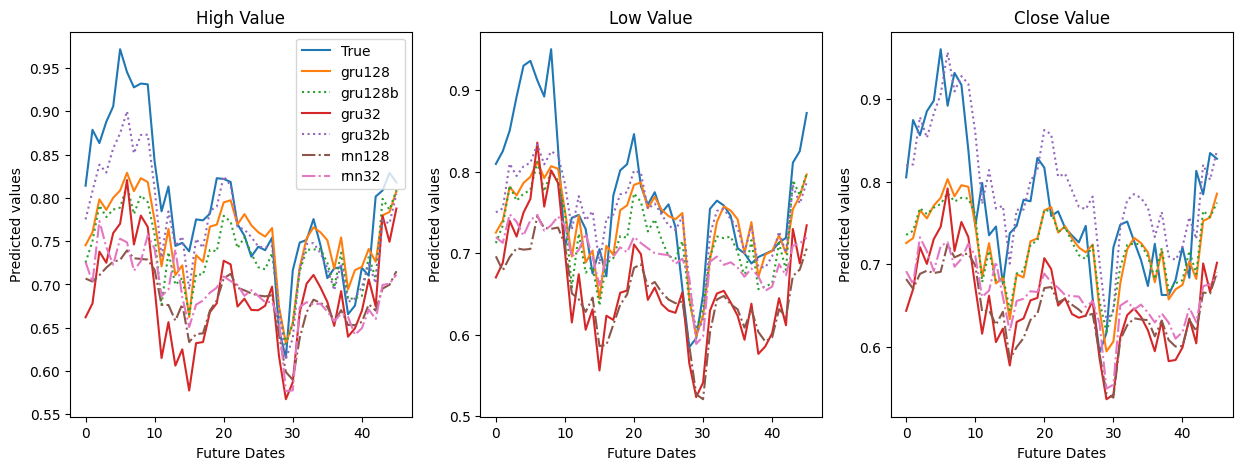

In [39]:
plot(test_features, test_lables, models)

In [ ]:
import tensorflow as tf

In [ ]:
tf.__version__

get test indexes for 4/21, 4/28, and 5/5

In [60]:
idxs = [data[data.Date == date].index[0] for date in ["2024-04-21", "2024-04-28", "2024-05-05"]] - idx_split - window_size
idxs

array([18, 25, 32])

get next predictions for a week from each startind date

In [95]:
id = data['Close'].index[data.Date=="2024-05-05"][0]
dat = data['Close'][id : id+7]

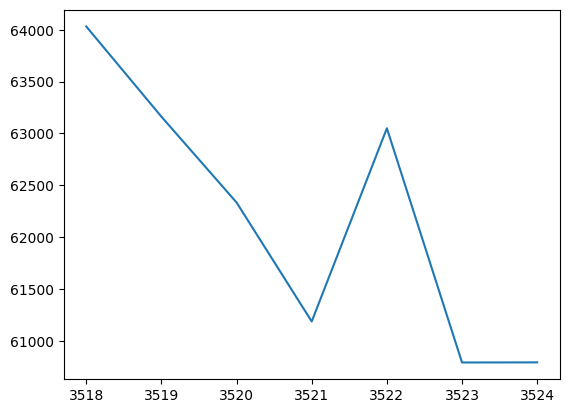

In [96]:
plt.plot(dat)

Next week predictions from 2024-04-06
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


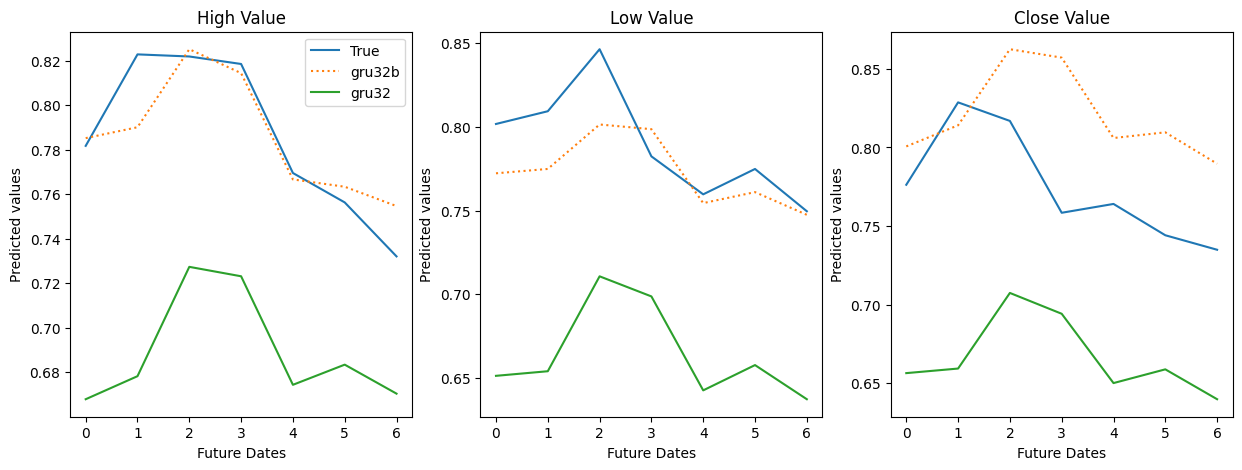

Next week predictions from 2024-04-13
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


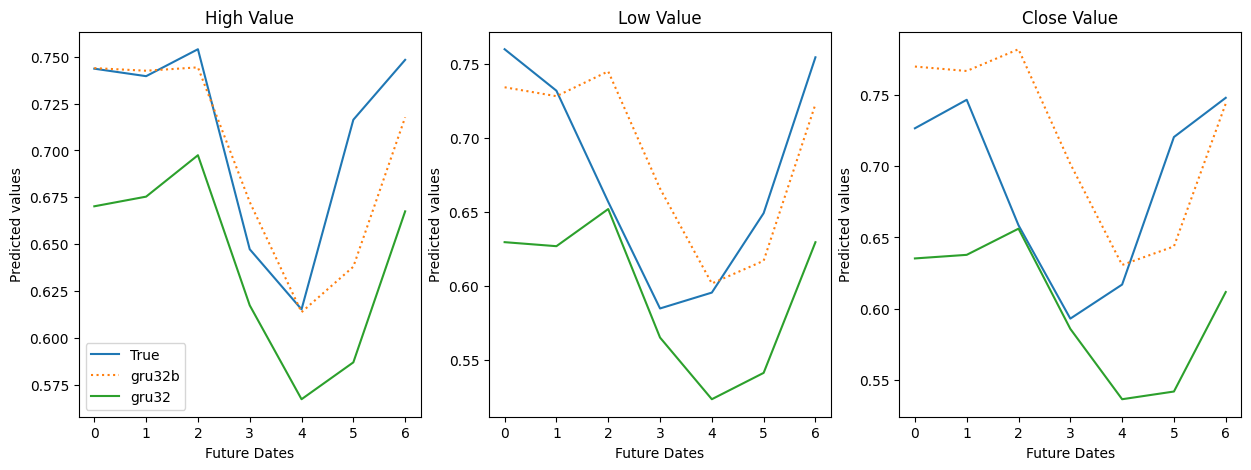

Next week predictions from 2024-04-20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


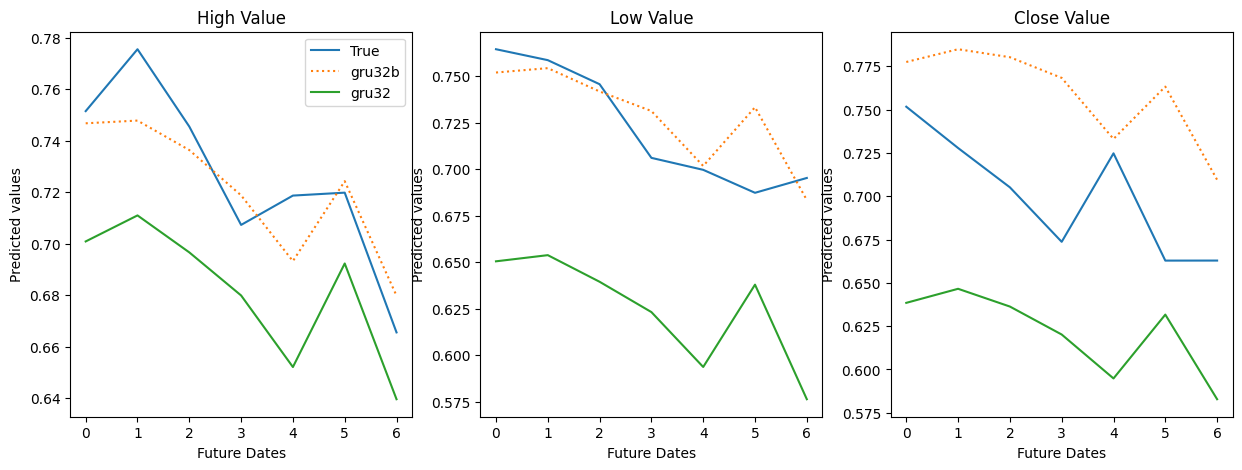

In [70]:
for idx in idxs:
    print(f"Next week predictions from {data.Date[idx + idx_split]}")
    x_data = test_features[idx : idx + 7]
    y_data = test_lables[idx : idx + 7]
    plot(x_data, y_data, {"gru32b": gru32b, "gru32": gru32})